# Time series project

In [3]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Step 1: Data collection

In [5]:
data = pd.read_csv("Aquifer_Petrignano.csv")
data.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


### Step 2: Exploration and data cleaning

In [6]:
# Obtain dimensions
data.shape

(5223, 8)

In [7]:
# Obtain information about data types and non-null values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB
None


In [8]:
null_data=pd.DataFrame(data.isnull().sum().sort_values(ascending=False))
null_data.columns=['Null Values']
null_data

,Null Values
Rainfall_Bastia_Umbra,1024
Hydrometry_Fiume_Chiascio_Petrignano,1024
Temperature_Petrignano,1024
Temperature_Bastia_Umbra,1024
Volume_C10_Petrignano,198
Depth_to_Groundwater_P24,55
Depth_to_Groundwater_P25,39
Date,0


In [9]:
# Deleting the NaN values from the DataFrame
data_dropped=data.dropna().reset_index(drop=True)

In [10]:
print(f"I eliminated the rows with NaN values, reducing the DataFrame from ({len(data)}, {len(data.columns)}) to ({len(data_dropped)}, {len(data_dropped.columns)})")

I eliminated the rows with NaN values, reducing the DataFrame from (5223, 8) to (4150, 8)


In [11]:
data_c=data_dropped.copy()
data_c.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
1,02/01/2009,0.0,-32.03,-31.11,2.3,2.5,-28785.888,2.5
2,03/01/2009,0.0,-31.97,-31.07,4.4,3.9,-25766.208,2.4
3,04/01/2009,0.0,-31.91,-31.05,0.8,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.94,-31.01,-1.9,-2.1,-29854.656,2.3


In [12]:
# Combine the columns with the same features
data_c['Depth_to_Groundwater']=round(((data_c['Depth_to_Groundwater_P24'] + data_c['Depth_to_Groundwater_P25'])/(2)),2)
data_c['Temperature']=round(((data_c['Temperature_Bastia_Umbra'] + data_c['Temperature_Petrignano'])/(2)),2)

In [13]:
# Remove not useful columns
data_c = data_c.drop(columns=['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Temperature_Petrignano'])
data_c.head()

,Date,Rainfall_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,Depth_to_Groundwater,Temperature
0,01/01/2009,0.0,-24530.688,2.4,-31.55,5.05
1,02/01/2009,0.0,-28785.888,2.5,-31.57,2.40
2,03/01/2009,0.0,-25766.208,2.4,-31.52,4.15
3,04/01/2009,0.0,-27919.296,2.4,-31.48,0.80
4,05/01/2009,0.0,-29854.656,2.3,-31.48,-2.00


In [14]:
# Simplify column names
data_c.columns= ['Date', 'Rainfall', 'Volume',	'Hydrometry',	'Depth_to_Groundwater',	'Temperature']

In [15]:
# Changing the format to the 'Date' column
data_c['Date'] = pd.to_datetime(data_c['Date'], format = '%d/%m/%Y')

In [16]:
# Ordering the columns of the DataFrame
data_c=data_c.reindex(['Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume', 'Depth_to_Groundwater'], axis=1)
data_c.head()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
0,2009-01-01,0.0,5.05,2.4,-24530.688,-31.55
1,2009-01-02,0.0,2.40,2.5,-28785.888,-31.57
2,2009-01-03,0.0,4.15,2.4,-25766.208,-31.52
3,2009-01-04,0.0,0.80,2.4,-27919.296,-31.48
4,2009-01-05,0.0,-2.00,2.3,-29854.656,-31.48


### Step 3: Analysis of univariate variables

Analysis on numeric variables

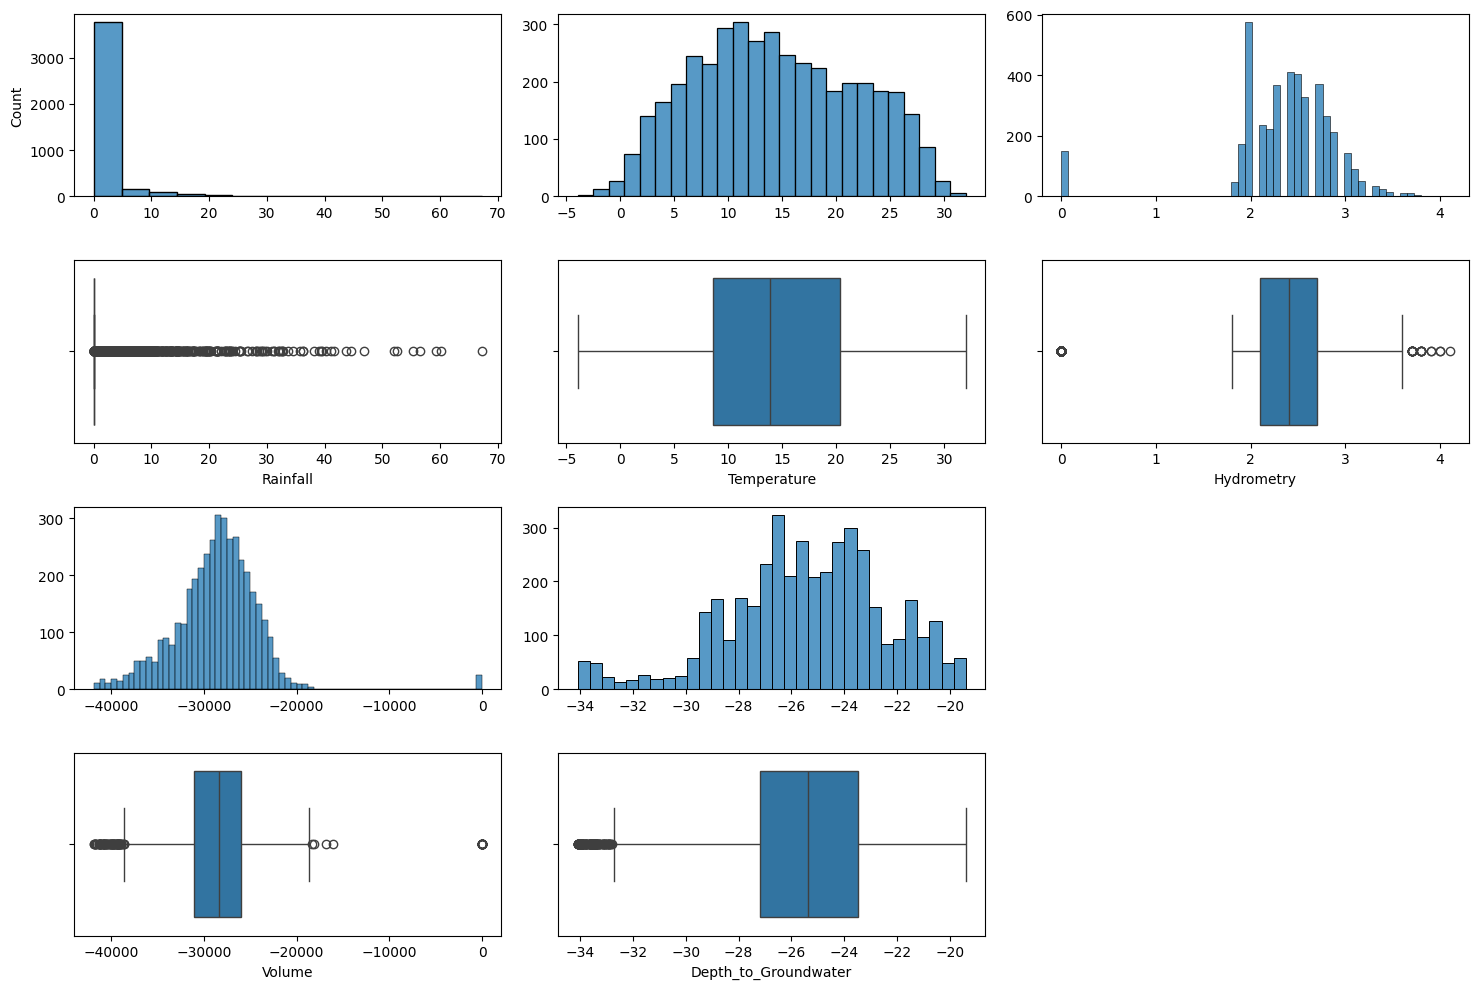

In [17]:
fig, axis = plt.subplots(4, 3, figsize = (15, 10))

# Creating a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = data_c, x = "Rainfall").set(xlabel = None)
sns.boxplot (ax = axis[1, 0], data = data_c, x = "Rainfall")

sns.histplot(ax = axis[0, 1], data = data_c, x = "Temperature").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[1, 1], data = data_c, x = "Temperature")

sns.histplot(ax = axis[0, 2], data = data_c, x = "Hydrometry").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[1, 2], data = data_c, x = "Hydrometry")

sns.histplot(ax = axis[2, 0], data = data_c, x = "Volume").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[3, 0], data = data_c, x = "Volume")

sns.histplot(ax = axis[2, 1], data = data_c, x = "Depth_to_Groundwater").set(xlabel = None, ylabel = None)
sns.boxplot (ax = axis[3, 1], data = data_c, x = "Depth_to_Groundwater")

# Adjust the layout
plt.tight_layout()

fig.delaxes(axis[2, 2])
fig.delaxes(axis[3, 2])

# Show the plot
plt.show()

### Step 4: Analysis of multivariate variables

<Axes: >

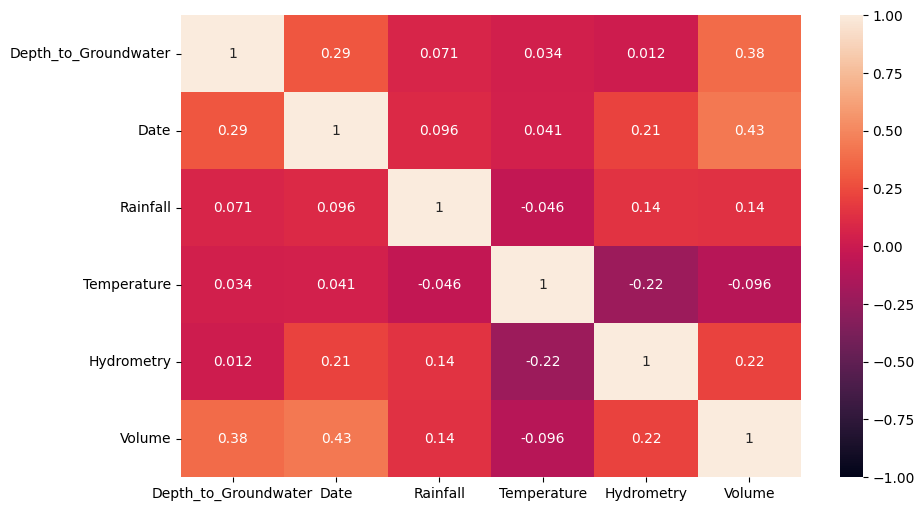

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(data_c[['Depth_to_Groundwater', 'Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume']].corr().round(3),vmax=1,vmin=-1,annot=True)

In [19]:
print("The features with the strongest relationship with Depth to Ground are Volume, Date and Rainfall.")

The features with the strongest relationship with Depth to Ground are Volume, Date and Rainfall.
